In [1]:
from PyLQR.sim import KDLRobot
from PyLQR.system import PosOrnPlannerSys,PosOrnKeypoint
from PyLQR.solver import AL_ILQR, ILQRRecursive
from PyLQR.utils import primitives, PythonCallbackMessage
import numpy as np

import matplotlib.pyplot as plt

# PyLQR: Position/Orientation planner or tracker with Augmented Lagrangian iLQR example

In this example, we will present how to use iLQR to plan or track a system that has for target space $\mathbf{\mu}_t$ :

* position ``[x,y,z]``
* orientation (in quaternion) ``[w,x,y,z]``

$$
    \mathbf{\mu}_t = \lbrack x \ y \ z \ w \ x \ y \ z \rbrack^\top
$$

For state space $\mathbf{x}_t$ (it is a latent space):

* joint positions $\mathbf{q}$

$$
    \mathbf{x}_t = \lbrack \mathbf{q}^\top \rbrack^\top
$$

For command space $\mathbf{u}_t$:

* joint velocities $\mathbf{\dot{q}}$

$$
    \mathbf{u}_t = \lbrack \mathbf{\dot{q}}^\top \rbrack^\top
$$

<span style="color:red">**The target space is get with the forward kinematics function with $\mathbf{x}_t$  as robot configuration**</span>

In [2]:
# Global task variables
dof = 7
nb_state_var = dof # [q,t]
nb_ctrl_var = dof  # [dq,sqrt(dt)]
nb_fox_var = 7 # [pos,orn,t]
horizon=400
dt = 0.01

## Definition of the robot object

The first to do is to create the abstraction of the robot that we want to control. Here we will a robot's abstraction based on the KDL library. The ``KDLRobot`` class requires:

* An URDF file describing the robot that we want to use.
* The name of the base frame in the URDF
* The name of the tip frame in the URDF
* Initial joint configuration

This class will *simulate* the kinematics evolution of the Panda robot in function of the control command that we will send to him.

In [3]:
PATH_TO_URDF = "model.urdf"
BASE_FRAME = "panda_link0"
TIP_FRAME = "panda_tip"
q0 = [ 0.62991112, -0.2329776 , -0.01423721, -1.70254115,  0.06251303, # Initial joint configuration of the robot
        1.50592777,  0.71771416]
dq0 = [0]*dof

qMax = np.array([np.pi]*dof)*10
dqMax = np.array([10]*dof)
rbt = KDLRobot(PATH_TO_URDF,BASE_FRAME,TIP_FRAME,q0,dq0)

## Task & system definition

Now that we have an object simulating the kinematics of our robot, we have to build a system object that will describe the task that we want to perform. Here since we are looking to optimize position and orientation
we will instantiate an object of type ``PosOrnPlannerSys``. To create this object, we need:

* A list of Keypoints (here ``PosOrnKeypoint``), each element in this list represents a keypoint, it contains:
  * A position target
  * An orientation target
  * A precision matrix
  * A discrete time value (discrete time of occurence)
* Joint limits/special end-effector transforms. Optional (see below).
* Some extra-information about the system:
  * Control command penalty (rfactor)
  * Horizon of the problem
  * Order of the system (in this example it's 1)
  * The discrete time step (dt)

In [4]:
target1_pos = np.array([0.554121212377707,      #x (position)
            -0.01575049935289518,  #y (position)
            0.38295604872511507])   #z (position)

target1_orn = np.array([0.014042440828406944,  #w (quaternion)
            0.915047647731553,     #x (quaternion)
            0.4024820607528928,    #y (quaternion)
            0.022333898196169735])  #z (quaternion)

Qtarget1 = np.diag([1, # Tracking the x position
            1, # Tracking the y position
            1, # Tracking the z position
            .1, # Tracking orientation around x axis
            .1, # Tracking orientation around y axis
            .1]) # Tracking orientation around z axis

target1_discrete_time = horizon//2 - 1

keypoint_1 = PosOrnKeypoint(target1_pos,target1_orn,Qtarget1,target1_discrete_time)

# Similarly for the second target:

target2_pos = np.array([0.254121212377707,
            -0.07575049935289518,
            0.13170744424127526])

target2_orn = np.array([0.029927010072216945,
            0.9121514607332729,
            0.4087591864532181,
            0.00011933313484481926])

Qtarget2 = np.diag([1,
            1,
            1,
            .1,
            .1,
            .1]) 

target2_discrete_time = horizon -1
keypoint_2 = PosOrnKeypoint(target2_pos,target2_orn,Qtarget2,target2_discrete_time)

cmd_penalties = (np.ones(nb_ctrl_var)*1e-5).tolist() # Each control signals have a penalty of 1e-5

keypoints = [keypoint_1,keypoint_2]

# It is not mandatory to set the limits, if you do not know them yet or do not want to use them. You can use this constructor:
# sys = PosOrnPlannerSys(rbt,keypoints,cmd_penalties,horizon,1,dt)
sys = PosOrnPlannerSys(rbt,keypoints,cmd_penalties,qMax,-qMax,dqMax,-dqMax,horizon,1,dt) 

## Solver definition

Now that the robot and system object are defined, we will define two different solvers to optimize the system:

* A standard iLQR
* An AL-iLQR algorithm

We will firstly solve the task with the first solver and try to add a constraint to see how the result evolve with the AL-iLQR algorithm.

In [5]:
u0_t = np.array([0]*(nb_ctrl_var-1) + [0])
u0 = np.tile(u0_t,horizon-1)

planner1 = ILQRRecursive(sys)
cb = PythonCallbackMessage() # callback to notify python code of the solver evolution

In [6]:
%%time
X1,F_X1,U1,K1,k1,cost = planner1.solve(u0.reshape((-1,nb_ctrl_var)),10,True,True,cb)

Iteration 1, Cost: 0.203963, alpha= 1, time= 0.00515143
Iteration 2, Cost: 0.0445521, alpha= 1, time= 0.00612918
Iteration 3, Cost: 0.00237588, alpha= 1, time= 0.00516519
Iteration 4, Cost: 0.000108483, alpha= 1, time= 0.00532445
Iteration 5, Cost: 3.72976e-05, alpha= 1, time= 0.00513549
Iteration 6, Cost: 3.73015e-05, alpha= 0.000976562, time= 0.0266443
CPU times: user 59 ms, sys: 0 ns, total: 59 ms
Wall time: 58.5 ms


<IPython.core.display.Javascript object>


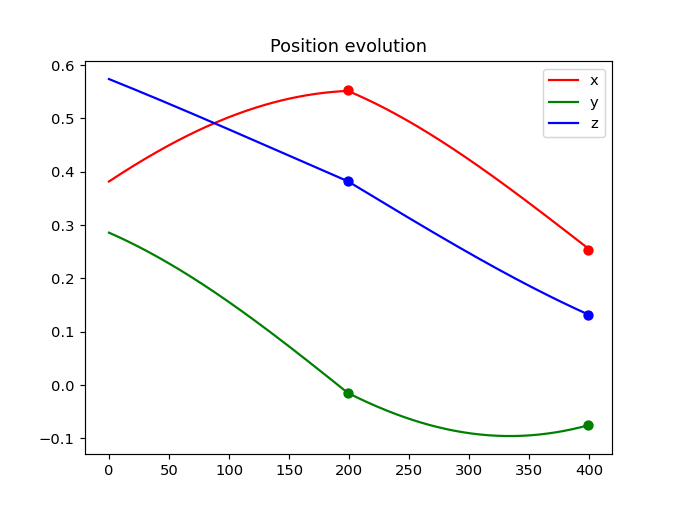

<IPython.core.display.Javascript object>


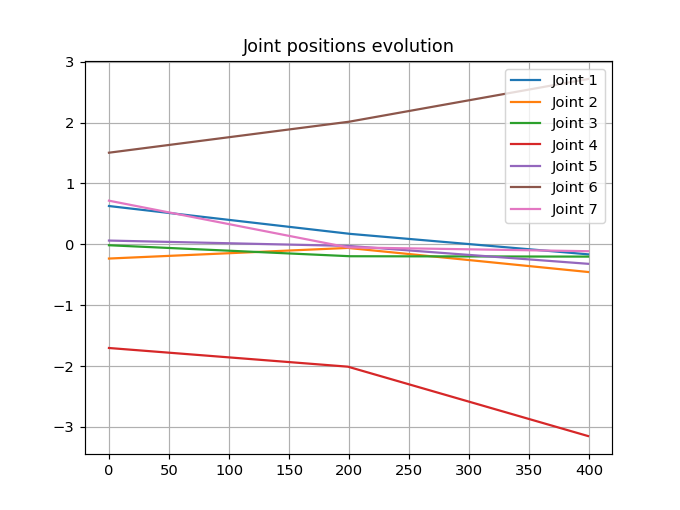

In [7]:
%matplotlib notebook
F_X1 = np.asarray(F_X1)
X1 = np.asarray(X1)

plt.figure()
plt.title('Position evolution')
plt.plot(F_X1[:,0],c='r',label='x')
plt.plot(F_X1[:,1],c='g',label='y')
plt.plot(F_X1[:,2],c='b',label='z')

plt.scatter(target1_discrete_time,target1_pos[0],c='r')
plt.scatter(target1_discrete_time,target1_pos[1],c='g')
plt.scatter(target1_discrete_time,target1_pos[2],c='b')

plt.scatter(target2_discrete_time,target2_pos[0],c='r')
plt.scatter(target2_discrete_time,target2_pos[1],c='g')
plt.scatter(target2_discrete_time,target2_pos[2],c='b')
plt.legend()

plt.figure()
plt.title('Joint positions evolution')
plt.grid(True)
for i in range(dof):
    plt.plot(X1[:,i],label="Joint "+str(i+1))
plt.legend()
    

Now that we have an idea about how the system is solved without any constraints, let's try to add one and see what is happening. For the purpose of this notebook, let's say that we want ``joint 6`` to always be under ``2.0``. A constraint can be constructed with the struct ``Constraint`` of the ``PyLQR.solver`` module. All constraints are inequality constraints and take the form:

$$
    \mathbf{A}_t \mathcal{S}_t \leq \mathbf{b}
$$
With:
$$
    \mathcal{S}_t = \lbrack \mathbf{x}_t^\top \ \mathbf{u}_t^\top \rbrack^\top
$$

In [8]:
from PyLQR.solver import Constraint

A = np.zeros(( nb_state_var+nb_ctrl_var , nb_state_var+nb_ctrl_var ))
b = np.zeros(nb_state_var+nb_ctrl_var)
A[5,5] = 1
b[5] = 2.0

constraints = []
init_multipliers = []

for i in range(horizon-1):
    c = Constraint()
    c.A = A
    c.b = b
    constraints += [c]
    init_multipliers += [b]
    
planner2 = AL_ILQR(sys,constraints,init_multipliers)

Now that the constraints are defined, we can try to solve our problem. Augmented Lagrangian techniques come with hyper-parameters that we need to fine-tune carefully:

* Update frequency of the Lagrange multipliers: ``lag_update_step``
* The weight of the inequality constraints: ``penalty``
* How the weight of the inequality constraints evolve: ``scaling_factor``

Sometimes, fine tuning these parameter could be really difficult, as a general recipe, we would like the constraints to have a minimal impact during the beginning of the optimization to let the solver find a solution and increase it after.

In [9]:
%%time
X2,F_X2,U2 = planner2.solve( u0.reshape(( -1,nb_ctrl_var )) , 100 ,5 , .25, 1.1, True, True, cb )

Iteration 1, Cost: 0.495126, alpha= 0.0625, time= 0.0182841
Iteration 2, Cost: 0.495336, alpha= 0.000976562, time= 0.034242
Iteration 3, Cost: 0.495553, alpha= 0.000976562, time= 0.0344365
Iteration 4, Cost: 0.495774, alpha= 0.000976562, time= 0.0332133
Iteration 5, Cost: 0.496001, alpha= 0.000976562, time= 0.0321657
Iteration 6, Cost: 0.494811, alpha= 0.0625, time= 0.0157584
Iteration 7, Cost: 0.493298, alpha= 0.125, time= 0.0127476
Iteration 8, Cost: 0.493314, alpha= 0.000976562, time= 0.027264
Iteration 9, Cost: 0.493309, alpha= 0.000976562, time= 0.0266053
Iteration 10, Cost: 0.49329, alpha= 0.00195312, time= 0.0243606
Iteration 11, Cost: 0.491129, alpha= 0.015625, time= 0.0182003
Iteration 12, Cost: 0.442421, alpha= 0.125, time= 0.0121217
Iteration 13, Cost: 0.43535, alpha= 0.25, time= 0.0101212
Iteration 14, Cost: 0.369963, alpha= 0.25, time= 0.0100606
Iteration 15, Cost: 0.269327, alpha= 0.25, time= 0.0101448
Iteration 16, Cost: 0.223143, alpha= 0.125, time= 0.014288
Iteration 1

<IPython.core.display.Javascript object>


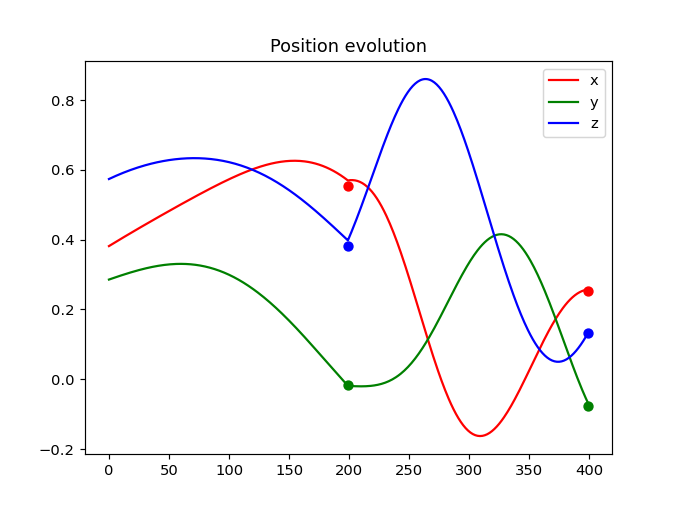

<IPython.core.display.Javascript object>


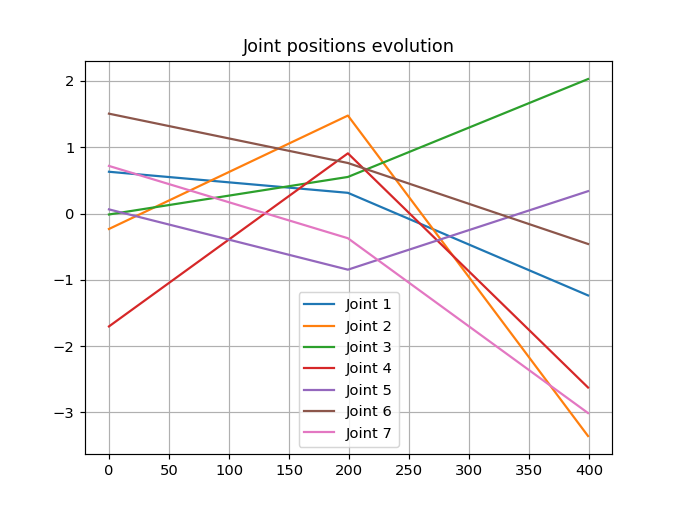

In [10]:
F_X2 = np.asarray(F_X2)
X2 = np.asarray(X2)

plt.figure()
plt.title('Position evolution')
plt.plot(F_X2[:,0],c='r',label='x')
plt.plot(F_X2[:,1],c='g',label='y')
plt.plot(F_X2[:,2],c='b',label='z')

plt.scatter(target1_discrete_time,target1_pos[0],c='r')
plt.scatter(target1_discrete_time,target1_pos[1],c='g')
plt.scatter(target1_discrete_time,target1_pos[2],c='b')

plt.scatter(target2_discrete_time,target2_pos[0],c='r')
plt.scatter(target2_discrete_time,target2_pos[1],c='g')
plt.scatter(target2_discrete_time,target2_pos[2],c='b')
plt.legend()

plt.figure()
plt.title('Joint positions evolution')
plt.grid(True)
for i in range(dof):
    plt.plot(X2[:,i],label="Joint "+str(i+1))
plt.legend()

**As you can see the solver managed to find a suitable solution with the constraints. You should be careful with this technique and always keep in mind that the applied constraints are soft. We only have the possibility to set constraints at the joint level, regarding how difficult it is for the solver to optimze the problem, adding constraints on the task space level could be really difficult to optimize**